<a href="https://colab.research.google.com/github/ngcheeyuan/Learner-s-Repo-for-Tensorflow/blob/main/08_nlp_with_tensorflow_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-01-18 12:28:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-18 12:28:24 (71.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import unzip_data , create_tensorboard_callback, plot_loss_curves , compare_historys

In [3]:
## Get a text dataset - disaster / not disaster
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data('nlp_getting_started.zip')

--2022-01-18 12:28:28--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 74.125.70.128, 74.125.132.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2022-01-18 12:28:28 (102 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
import pandas as pd

In [5]:
df_train = pd.read_csv('train.csv')

In [6]:
df_test = pd.read_csv('test.csv')

In [7]:
df_test.head(5) # no labels in test data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
X = df_train['text']
y = df_train['target']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train , X_val , y_train, y_val = train_test_split(X,y,test_size = 0.25, stratify = y)

In [12]:
y_train.mean(),y_val.mean() , len(X_train), len(y_val)

(0.4296724470134875, 0.42962184873949577, 5709, 1904)

In [13]:
df = pd.concat([X_train,y_train] , axis = 1)

In [14]:
#Let's visualise some random training examples

import random
random_index = random.randint(0,len(X_train)-5)

for row in df[random_index:random_index+5].itertuples():
 _,text,target = row
 print(f'target : {target}', 'real_disaster\n' if target >0 else 'not_disaster\n' , f'text : {text}\n')
 print('------\n')

target : 1 real_disaster
 text : EXCLUSIVE: In 179 fatalities involving on-duty NYPD cops in 15 years only 3åÊÛ_ http://t.co/Cn1joMMUGH

------

target : 1 real_disaster
 text : The Latest: More homes razed by Northern California wildfire - http://t.co/2nIP3d15dx http://t.co/egYFNlAOQv

------

target : 1 real_disaster
 text : @Hurricane_Dolce no prob

------

target : 0 not_disaster
 text : New Giant Flames (Giant Manly Brown) info/order sms:087809233445 pin:2327564d http://t.co/T1mBw0ia3o  http://t.co/CLfa0PY5Lm

------

target : 0 not_disaster
 text : I am that girl on tv that sadly turns her music up to drown out the noise of her family fighting literally every day

------



## tokenization & embedding

* tokenization - straight character/word/subword to number

* embedding - every word becomes a vector - richer representation between tokens -Word2Vec , GloVe

In [15]:
## tokenization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [16]:
text_vec = TextVectorization(max_tokens= 5000,
                             standardize = 'lower_and_strip_punctuation',
                             split = 'whitespace',
                             ngrams = None,
                             output_mode = 'int',
                             output_sequence_length = None, #pad text to have the same length as the longest text,
                             pad_to_max_tokens = True)

In [17]:
#Average number of tokens in the training tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

15

In [18]:
#setup text vectorization variables

max_vocab_length = 10000 # max num of words to have in our vocab
max_length = 15 # max length of our sequence

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_sequence_length = max_length)

In [19]:
#Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [20]:
#create a sample sentence and tokenize it

sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[347,   3, 247,   5,  13, 844,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
#choose a random sentence from the training dataset and tokenize it

random_sentence = random.choice(X_train)

print(f'original text:\n {random_sentence} \
        \n\nVectorized version:')
text_vectorizer([random_sentence])

original text:
 @marksmaponyane Hey!Sundowns were annihilated in their previous meeting with Celtic.Indeed its an improvement.         

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[9800,    1,   68,  637,    5,  119, 2460, 1591,   15,    1,   42,
          43,    1,    0,    0]])>

In [22]:
# get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

In [23]:
len(words_in_vocab),top_5_words , bottom_5_words

(10000,
 ['', '[UNK]', 'the', 'a', 'to'],
 ['lonepine', 'lonelyness', 'london3', 'lomasvisto', 'lolo'])

### Create an embedding layer 
reference : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* input_dims = the size of our vocabulary
* output_dims = the size of the output embedding vector, a value of 100 would mean each token gets represented by a vector 100 long
* input_lnegth = length of the sequence being passed to the embedding layer 

In [24]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             input_length = max_length)
embedding

In [25]:
import random

In [26]:
random_sentence = random.choice(X_train)

In [27]:
print(f'original sentence: {random_sentence}')
print('embedded sentence: \n')
sampled_embed = embedding(text_vectorizer([random_sentence]))
sampled_embed

original sentence: European Fitba till Christmas  ARMAGEDDON
embedded sentence: 



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01383701,  0.03119907,  0.04768028, ..., -0.02517147,
          0.04949797, -0.04548668],
        [ 0.01383701,  0.03119907,  0.04768028, ..., -0.02517147,
          0.04949797, -0.04548668],
        [ 0.04535497,  0.03679568,  0.00134114, ...,  0.01035037,
          0.02442044, -0.02157302],
        ...,
        [ 0.04935987,  0.04897379,  0.04793494, ..., -0.01913549,
          0.02610569,  0.0373273 ],
        [ 0.04935987,  0.04897379,  0.04793494, ..., -0.01913549,
          0.02610569,  0.0373273 ],
        [ 0.04935987,  0.04897379,  0.04793494, ..., -0.01913549,
          0.02610569,  0.0373273 ]]], dtype=float32)>

In [28]:
sampled_embed[0][0],sampled_embed[0][0].shape, random_sentence, text_vectorizer([random_sentence])

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.01383701,  0.03119907,  0.04768028, -0.0124943 ,  0.01745861,
        -0.03849894, -0.00029136, -0.0144999 , -0.0292614 , -0.0165463 ,
         0.04187385, -0.02468996, -0.01655411, -0.04088801,  0.00785475,
         0.02605924, -0.00303196,  0.00825418, -0.03228737,  0.03974101,
         0.00919332, -0.00609929,  0.01113145,  0.03242484,  0.02333131,
         0.00464442, -0.01871241,  0.01792694,  0.02578655, -0.03825564,
        -0.00181037, -0.0078031 ,  0.0065101 ,  0.01027864, -0.04877069,
         0.00509499, -0.01112198,  0.0339738 , -0.01553364,  0.04964539,
        -0.01392425, -0.02970059, -0.01035862, -0.03744185,  0.00081931,
         0.01208103, -0.02768211,  0.02406133, -0.03232223, -0.00611378,
        -0.00070164,  0.03792281,  0.02059597, -0.03198813,  0.04739946,
        -0.0357471 , -0.02761414, -0.02791747,  0.03176472, -0.01610593,
        -0.0023564 , -0.04161304,  0.01541504, -0.01674304,  0.00861664,
  

# Modelling a text dataset
* 0 - baseline - Naive Bayes with TF-ID encoder
* 1 - feed-forwad neural network
* 2 - LSTM (RNN)
* 3 - GRU (RNN)
* 4 - Bidirectional-LSTM(RNN)
* 5 - 1D CNN
* 6 - Tensorhub Pretrained Feature Extractor (Transfer learning)
* 7 - Tensorhub Pretrained Feature Extract (10% of data)

### Moel 0 : getting a baseline

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [30]:
model_0 = Pipeline([('tfidf',TfidfVectorizer()),
                     ('clf',MultinomialNB())])

In [31]:
model_0.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
baseline_score_train = model_0.score(X_train,y_train)
baseline_score_val = model_0.score(X_val,y_val)
baseline_score_train,baseline_score_val

(0.8891224382553863, 0.8014705882352942)

In [34]:
from sklearn.metrics import accuracy_score, f1_score , precision_score, recall_score
from sklearn.metrics import classification_report

In [35]:
def evaluation_metrics(y_preds_train,
                       y_preds_val,
                       y_train,
                       y_val):
  
  '''
  Calculates model accuracy, precision, recall, f1 score of a binary classification model
  '''


 # can use precision_recall_fscore_support 

  return {'accuracy_train':accuracy_score(y_train,y_preds_train),
          'accuracy_val':accuracy_score(y_val,y_preds_val),
          'precision_train':precision_score(y_train,y_preds_train),
          'precision_val':precision_score(y_val,y_preds_val),
          'recall_train':recall_score(y_train,y_preds_train),
          'recall_val':recall_score(y_val,y_preds_val),
          'f1_train':f1_score(y_train,y_preds_train,),
          'f1_val':f1_score(y_val,y_preds_val)}

In [36]:
y_pred_train = model_0.predict(X_train)
y_pred_val = model_0.predict(X_val)
baseline_results = evaluation_metrics(y_pred_train,y_pred_val,y_train,y_val)
baseline_results

{'accuracy_train': 0.8891224382553863,
 'accuracy_val': 0.8014705882352942,
 'f1_train': 0.856690061127462,
 'f1_val': 0.7330508474576272,
 'precision_train': 0.9633401221995926,
 'precision_val': 0.8678929765886287,
 'recall_train': 0.7713004484304933,
 'recall_val': 0.6344743276283619}

### Model 1 : Feed-forward neural network (dense model)

In [37]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

#create a directory to save tensorboard logs
SAVE_DIR = 'model_logs'

In [38]:
#build model with functional API
from tensorflow.keras import layers
inputs = layers.Input(shape =(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) #condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs,outputs,name = 'model_1_dense')

In [39]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [40]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [41]:
#Compile model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [42]:
model_1_history = model_1.fit(x=X_train,
                              y=y_train,
                              epochs = 5,
                              validation_data = (X_val,y_val),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = 'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20220118-122833
Epoch 1/5
179/179 [==============================] - 4s 9ms/step - loss: 0.6279 - accuracy: 0.6786 - val_loss: 0.5502 - val_accuracy: 0.7484
Epoch 2/5
179/179 [==============================] - 1s 8ms/step - loss: 0.4642 - accuracy: 0.8101 - val_loss: 0.4649 - val_accuracy: 0.7962
Epoch 3/5
179/179 [==============================] - 1s 8ms/step - loss: 0.3614 - accuracy: 0.8572 - val_loss: 0.4423 - val_accuracy: 0.7962
Epoch 4/5
179/179 [==============================] - 1s 8ms/step - loss: 0.2933 - accuracy: 0.8889 - val_loss: 0.4386 - val_accuracy: 0.7941
Epoch 5/5
179/179 [==============================] - 1s 8ms/step - loss: 0.2421 - accuracy: 0.9131 - val_loss: 0.4505 - val_accuracy: 0.7925


In [43]:
model_1.evaluate(X_val,y_val)

60/60 [==============================] - 0s 4ms/step - loss: 0.4505 - accuracy: 0.7925


[0.4504808485507965, 0.792542040348053]

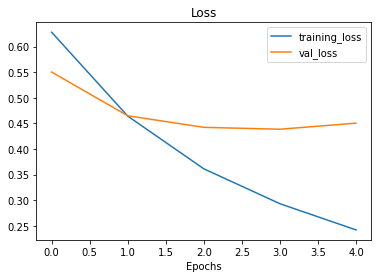

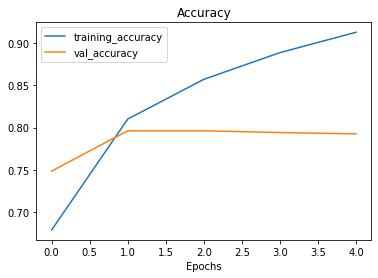

In [44]:
plot_loss_curves(model_1_history)

In [45]:
model_1_pred_probs = model_1.predict(X_val)
model_1_pred_probs.shape

(1904, 1)

In [46]:
model_1_pred_probs[0]

array([0.01585345], dtype=float32)

In [47]:
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1_corrected_history = model_1.fit(x=X_train,
                                        y=y_train,
                                        epochs = 5,
                                        validation_data = (X_val,y_val),
                                        callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                                experiment_name = 'model_1_dense_corrected')])

Saving TensorBoard log files to: model_logs/model_1_dense_corrected/20220118-122845
Epoch 1/5
179/179 [==============================] - 2s 9ms/step - loss: 0.2019 - accuracy: 0.9263 - val_loss: 0.4695 - val_accuracy: 0.7925
Epoch 2/5
179/179 [==============================] - 1s 7ms/step - loss: 0.1701 - accuracy: 0.9373 - val_loss: 0.4949 - val_accuracy: 0.7910
Epoch 3/5
179/179 [==============================] - 1s 8ms/step - loss: 0.1441 - accuracy: 0.9496 - val_loss: 0.5256 - val_accuracy: 0.7836
Epoch 4/5
179/179 [==============================] - 1s 8ms/step - loss: 0.1238 - accuracy: 0.9573 - val_loss: 0.5584 - val_accuracy: 0.7721
Epoch 5/5
179/179 [==============================] - 1s 7ms/step - loss: 0.1080 - accuracy: 0.9625 - val_loss: 0.5866 - val_accuracy: 0.7805


In [48]:
model_1.evaluate(X_val,y_val)

60/60 [==============================] - 0s 4ms/step - loss: 0.5866 - accuracy: 0.7805


[0.5865947008132935, 0.7804622054100037]

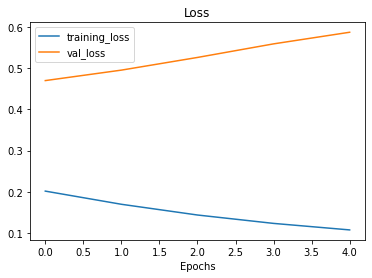

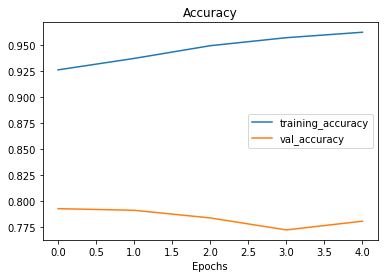

In [49]:
plot_loss_curves(model_1_corrected_history)

In [50]:
model_1_pred_probs_val = model_1.predict(X_val)
model_1_pred_probs_train = model_1.predict(X_train)

In [51]:
import numpy as np
model_1_preds_val = tf.cast(tf.squeeze(tf.round(model_1_pred_probs_val)), dtype = tf.int16)
model_1_preds_train = tf.cast(tf.squeeze(tf.round(model_1_pred_probs_train)), dtype = tf.int16)
model_1_preds_val,model_1_preds_train

(<tf.Tensor: shape=(1904,), dtype=int16, numpy=array([0, 1, 0, ..., 1, 0, 0], dtype=int16)>,
 <tf.Tensor: shape=(5709,), dtype=int16, numpy=array([1, 0, 0, ..., 1, 0, 0], dtype=int16)>)

In [52]:
model_1_results = evaluation_metrics(model_1_preds_train,
                                     model_1_preds_val,
                                     y_train,
                                     y_val)

In [53]:
model_1_results

{'accuracy_train': 0.9716237519705728,
 'accuracy_val': 0.7804621848739496,
 'f1_train': 0.9665979381443299,
 'f1_val': 0.7374371859296482,
 'precision_train': 0.9778890279516061,
 'precision_val': 0.7583979328165374,
 'recall_train': 0.9555646147574399,
 'recall_val': 0.71760391198044}

In [54]:
baseline_results

{'accuracy_train': 0.8891224382553863,
 'accuracy_val': 0.8014705882352942,
 'f1_train': 0.856690061127462,
 'f1_val': 0.7330508474576272,
 'precision_train': 0.9633401221995926,
 'precision_val': 0.8678929765886287,
 'recall_train': 0.7713004484304933,
 'recall_val': 0.6344743276283619}

In [55]:
np.array(list(model_1_results.values())) >np.array(list(baseline_results.values()))

array([ True, False,  True, False,  True,  True,  True,  True])

In [56]:
words_in_vocab = text_vectorizer.get_vocabulary()

In [57]:
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'to', 'in', 'of', 'and', 'i', 'is'])

In [58]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [60]:
#Get the weight matrix of embedding layer
# These are the numerical representation of each token in our training data 
embedded_weight = model_1.get_layer('embedding').get_weights()[0]

In [61]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [62]:
embedded_weight.shape

(10000, 128)

## Visualizing word embeddings
https://projector.tensorflow.org/



In [63]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embedded_weight[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


In [64]:
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass


## Recurrent Neural Network

RNN's are useful for sequence data

The premise of a recurrent network is to learn the representation of a previous input to aid the representation of a later input

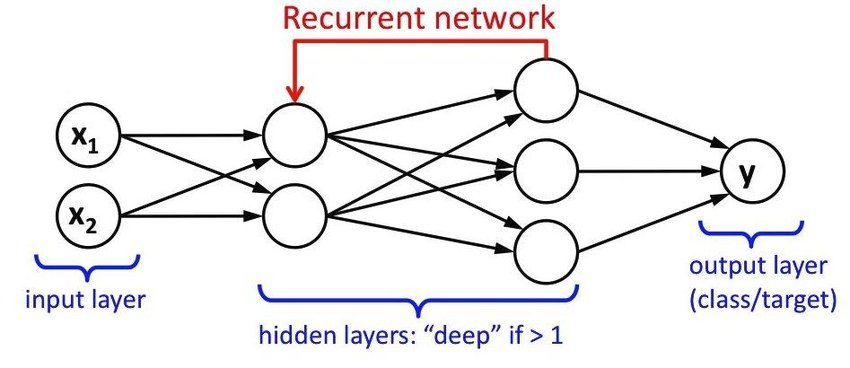

##Model 2 - LSTM - Long short term memory

Typical RNN structure

Inputer(text) ->Tokenize->Embedding ->Layer(RNN/Dense) -> Ouput

In [65]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units = 64, return_sequences=True)(x) #when you're stacking RNN cells , you need to return_sequences = True
# print(x.shape)
x = layers.LSTM(units = 64)(x)
# print(x.shape)
x = layers.Dense(64, activation = 'relu')(x)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs,outputs , name = 'model_2_LSTM')


In [66]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [67]:
#compile the model
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [68]:
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs = 5,
                              validation_data = (X_val,y_val),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'model_2_lstm')])

Saving TensorBoard log files to: model_logs/model_2_lstm/20220118-122917
Epoch 1/5
179/179 [==============================] - 7s 15ms/step - loss: 0.1498 - accuracy: 0.9581 - val_loss: 0.7031 - val_accuracy: 0.7752
Epoch 2/5
179/179 [==============================] - 2s 11ms/step - loss: 0.0810 - accuracy: 0.9688 - val_loss: 0.7328 - val_accuracy: 0.7705
Epoch 3/5
179/179 [==============================] - 2s 11ms/step - loss: 0.0710 - accuracy: 0.9713 - val_loss: 0.8173 - val_accuracy: 0.7652
Epoch 4/5
179/179 [==============================] - 2s 12ms/step - loss: 0.0626 - accuracy: 0.9737 - val_loss: 1.1124 - val_accuracy: 0.7642
Epoch 5/5
179/179 [==============================] - 2s 12ms/step - loss: 0.0551 - accuracy: 0.9762 - val_loss: 1.0131 - val_accuracy: 0.7589


In [69]:
model_2_pred_probs_val = tf.squeeze(tf.round(model_2.predict(X_val)))

In [70]:
model_2_pred_probs_train = tf.squeeze(tf.round(model_2.predict(X_train)))

In [71]:
model_2_pred_probs_train[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 1., 0., 0., 1., 0.], dtype=float32)>

In [72]:
model_2_results = evaluation_metrics(model_2_pred_probs_train,
                                     model_2_pred_probs_val,
                                     y_train, y_val)

In [73]:
model_2_results

{'accuracy_train': 0.9807321772639692,
 'accuracy_val': 0.7589285714285714,
 'f1_train': 0.977319587628866,
 'f1_val': 0.7161410018552876,
 'precision_train': 0.9887359198998749,
 'precision_val': 0.7246558197747184,
 'recall_train': 0.9661638809620873,
 'recall_val': 0.7078239608801956}

In [74]:
baseline_results

{'accuracy_train': 0.8891224382553863,
 'accuracy_val': 0.8014705882352942,
 'f1_train': 0.856690061127462,
 'f1_val': 0.7330508474576272,
 'precision_train': 0.9633401221995926,
 'precision_val': 0.8678929765886287,
 'recall_train': 0.7713004484304933,
 'recall_val': 0.6344743276283619}

## Model 3: GRU - gated recurrent unit

- similar to LSTM

In [75]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units = 64, return_sequences=True)(x) #when you're stacking RNN cells , you need to return_sequences = True
# print(x.shape)
x = layers.GRU(units = 64)(x)
# print(x.shape)
x = layers.Dense(64, activation = 'relu')(x)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
model_3 = tf.keras.Model(inputs,outputs , name = 'model_2_LSTM')


In [76]:
model_3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [77]:
model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs = 5,
                              validation_data = (X_val,y_val),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220118-122934
Epoch 1/5
179/179 [==============================] - 5s 16ms/step - loss: 0.1308 - accuracy: 0.9459 - val_loss: 0.8103 - val_accuracy: 0.7642
Epoch 2/5
179/179 [==============================] - 2s 11ms/step - loss: 0.0579 - accuracy: 0.9786 - val_loss: 0.9668 - val_accuracy: 0.7516
Epoch 3/5
179/179 [==============================] - 2s 11ms/step - loss: 0.0544 - accuracy: 0.9785 - val_loss: 0.8100 - val_accuracy: 0.7710
Epoch 4/5
179/179 [==============================] - 2s 11ms/step - loss: 0.0469 - accuracy: 0.9795 - val_loss: 0.9924 - val_accuracy: 0.7579
Epoch 5/5
179/179 [==============================] - 2s 12ms/step - loss: 0.0446 - accuracy: 0.9772 - val_loss: 1.2598 - val_accuracy: 0.7463


In [78]:
model_3_pred_probs_val = tf.squeeze(tf.round(model_3.predict(X_val)))
model_3_pred_probs_train = tf.squeeze(tf.round(model_3.predict(X_train)))

In [79]:
model_3_results = evaluation_metrics(model_3_pred_probs_train,
                                     model_3_pred_probs_val,
                                     y_train, y_val)

In [80]:
np.array(list(model_3_results.values())) >np.array(list(baseline_results.values()))

array([ True, False,  True, False,  True,  True,  True, False])

In [81]:
#encoder
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence,'When you can the universal sentence encoder on a sentence, it turns it into numbers'])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157024  0.0248591   0.0287805  -0.01271502  0.03971543  0.08827759
  0.02680986  0.05589837 -0.01068731 -0.0059729   0.00639324 -0.01819523
  0.00030817  0.09105891  0.05874644 -0.03180627  0.01512476 -0.05162928
  0.00991369 -0.06865346 -0.04209306  0.0267898   0.03011008  0.00321069
 -0.00337969 -0.04787359  0.02266718 -0.00985924 -0.04063614 -0.01292095
 -0.04666384  0.056303   -0.03949255  0.00517685  0.02495828 -0.07014439
  0.02871508  0.04947682 -0.00633971 -0.08960191  0.02807117 -0.00808362
 -0.01360601  0.05998649 -0.10361786 -0.05195372  0.00232955 -0.02332528
 -0.03758105  0.0332773 ], shape=(50,), dtype=float32)


In [82]:
sample_sentence

"There's a flood in my street!"

In [83]:
embed_samples[0].shape

TensorShape([512])

In [84]:
#Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = 'USE'
                                        )

In [85]:
#Create model using the Sequential API
model_6 = tf.keras.Sequential(
    [sentence_encoder_layer,
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
    ],name = 'model_6_USE'
)

In [86]:
model_6.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [87]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [88]:
#Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(X_train,y_train,
                              epochs = 5,
                              validation_data = (X_val,y_val),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220118-123011
Epoch 1/5
179/179 [==============================] - 8s 28ms/step - loss: 0.5240 - accuracy: 0.7796 - val_loss: 0.4326 - val_accuracy: 0.8020
Epoch 2/5
179/179 [==============================] - 4s 24ms/step - loss: 0.4228 - accuracy: 0.8105 - val_loss: 0.4174 - val_accuracy: 0.8125
Epoch 3/5
179/179 [==============================] - 4s 24ms/step - loss: 0.4057 - accuracy: 0.8196 - val_loss: 0.4145 - val_accuracy: 0.8183
Epoch 4/5
179/179 [==============================] - 4s 24ms/step - loss: 0.3957 - accuracy: 0.8254 - val_loss: 0.4191 - val_accuracy: 0.8157
Epoch 5/5
179/179 [==============================] - 5s 26ms/step - loss: 0.3897 - accuracy: 0.8280 - val_loss: 0.4114 - val_accuracy: 0.8188


In [89]:
model_6_pred_probs_val = model_6.predict(X_val)

In [90]:
#Convert prediction probabilities to labels
model_6_preds_val = tf.squeeze(tf.round(model_6_pred_probs_val))
model_6_preds_val

<tf.Tensor: shape=(1904,), dtype=float32, numpy=array([0., 1., 0., ..., 1., 0., 0.], dtype=float32)>

In [91]:
model_6_pred_probs_train = model_6.predict(X_train)
model_6_preds_train = tf.squeeze(tf.round(model_6_pred_probs_train))
model_6_preds_train

<tf.Tensor: shape=(5709,), dtype=float32, numpy=array([1., 0., 0., ..., 1., 1., 0.], dtype=float32)>

In [92]:
model_6_results = evaluation_metrics(model_6_preds_train,
                                     model_6_preds_val,
                                     y_train, y_val)

In [93]:
model_6_results

{'accuracy_train': 0.8360483447188649,
 'accuracy_val': 0.8188025210084033,
 'f1_train': 0.7996575342465753,
 'f1_val': 0.7803946530872057,
 'precision_train': 0.8418206399278955,
 'precision_val': 0.8140770252324038,
 'recall_train': 0.7615165103954341,
 'recall_val': 0.7493887530562348}

In [94]:
np.array(list(model_6_results.values())) >np.array(list(baseline_results.values()))

array([False,  True, False, False, False,  True, False,  True])

In [95]:
#Create model using the Sequential API
model_7 = tf.keras.Sequential(
    [sentence_encoder_layer,
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
    ],name = 'model_7_USE'
)

In [96]:
model_7.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [97]:
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [98]:
#Train a classifier on top of USE pretrained embeddings
model_7_history = model_7.fit(X_train,y_train,
                              epochs = 5,
                              validation_data = (X_val,y_val),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'tf_hub_sentence_encoder_2')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_2/20220118-123041
Epoch 1/5
179/179 [==============================] - 6s 27ms/step - loss: 0.5206 - accuracy: 0.7830 - val_loss: 0.4365 - val_accuracy: 0.8004
Epoch 2/5
179/179 [==============================] - 5s 26ms/step - loss: 0.4216 - accuracy: 0.8140 - val_loss: 0.4210 - val_accuracy: 0.8109
Epoch 3/5
179/179 [==============================] - 4s 24ms/step - loss: 0.4039 - accuracy: 0.8241 - val_loss: 0.4156 - val_accuracy: 0.8136
Epoch 4/5
179/179 [==============================] - 4s 24ms/step - loss: 0.3947 - accuracy: 0.8266 - val_loss: 0.4175 - val_accuracy: 0.8130
Epoch 5/5
179/179 [==============================] - 5s 26ms/step - loss: 0.3874 - accuracy: 0.8273 - val_loss: 0.4137 - val_accuracy: 0.8204


In [99]:
model_7_pred_probs_val = model_7.predict(X_val)

In [100]:
#Convert prediction probabilities to labels
model_7_preds_val = tf.squeeze(tf.round(model_7_pred_probs_val))
model_7_preds_val

<tf.Tensor: shape=(1904,), dtype=float32, numpy=array([0., 1., 0., ..., 1., 0., 0.], dtype=float32)>

In [101]:
model_7_pred_probs_train = model_7.predict(X_train)
model_7_preds_train = tf.squeeze(tf.round(model_7_pred_probs_train))
model_7_preds_train

<tf.Tensor: shape=(5709,), dtype=float32, numpy=array([1., 0., 0., ..., 1., 1., 0.], dtype=float32)>

In [102]:
model_7_results = evaluation_metrics(model_7_preds_train,
                                     model_7_preds_val,
                                     y_train, y_val)

In [103]:
model_7_results

{'accuracy_train': 0.837624802942722,
 'accuracy_val': 0.8203781512605042,
 'f1_train': 0.8010302640051514,
 'f1_val': 0.7829949238578681,
 'precision_train': 0.8458748866727108,
 'precision_val': 0.8139841688654353,
 'recall_train': 0.7607011822258459,
 'recall_val': 0.7542787286063569}

In [104]:
np.array(list(model_7_results.values())) >np.array(list(baseline_results.values()))

array([False,  True, False, False, False,  True, False,  True])

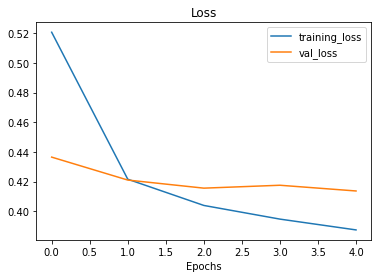

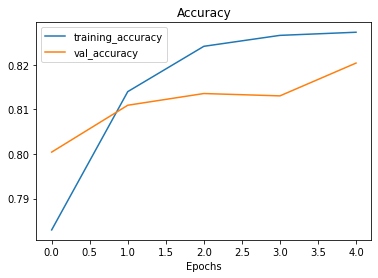

In [105]:
plot_loss_curves(model_7_history)

In [106]:
df

,text,target
2084,Man Found Dead in Demi Moore's Swimming Pool! ...,1
7088,Diageo's CEO stresses that a board revolt at U...,0
540,@funkflex yo flex im here https://t.co/2AZxdLCXgA,0
1881,kenny holland crush da vida,0
178,AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE...,0
...,...,...
3990,Granted like half my town floods when it rains...,1
3323,Wow. #FIFA16 has Pre Season Tournaments in Car...,0
7343,PHOTOS: The Rocky Fire has grown into Californ...,1
4796,Jrowah: Breaking news! Unconfirmed! I just hea...,1


#Model 7: TF Hub pretrained USE with 10% of the training data

In [107]:
df_new = df.sample(frac = 0.1)

In [109]:
X_sample = df_new['text'].copy()
y_sample = df_new['target'].copy()

In [110]:
# #Create model using the Sequential API
# model_8 = tf.keras.Sequential(
#     [sentence_encoder_layer,
#     layers.Dense(64, activation = 'relu'),
#     layers.Dense(1, activation = 'sigmoid')
#     ],name = 'model_7_USE'
# )

In [111]:
model_8 = tf.keras.models.clone_model(model_7)

In [112]:
model_8.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [113]:
model_8.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [114]:
#Train a classifier on top of USE pretrained embeddings
model_8_history = model_8.fit(X_sample,y_sample,
                              epochs = 5,
                              validation_data = (X_val,y_val),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'tf_hub_sentence_encoder_10%')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10%/20220118-123946
Epoch 1/5
18/18 [==============================] - 5s 123ms/step - loss: 0.6783 - accuracy: 0.6690 - val_loss: 0.6563 - val_accuracy: 0.7537
Epoch 2/5
18/18 [==============================] - 2s 94ms/step - loss: 0.6279 - accuracy: 0.7951 - val_loss: 0.6089 - val_accuracy: 0.7815
Epoch 3/5
18/18 [==============================] - 1s 78ms/step - loss: 0.5700 - accuracy: 0.8266 - val_loss: 0.5563 - val_accuracy: 0.7978
Epoch 4/5
18/18 [==============================] - 2s 96ms/step - loss: 0.5118 - accuracy: 0.8266 - val_loss: 0.5127 - val_accuracy: 0.7878
Epoch 5/5
18/18 [==============================] - 1s 73ms/step - loss: 0.4625 - accuracy: 0.8354 - val_loss: 0.4837 - val_accuracy: 0.7873


In [115]:
model_8_pred_probs_val = model_8.predict(X_val)

In [116]:
#Convert prediction probabilities to labels
model_8_preds_val = tf.squeeze(tf.round(model_8_pred_probs_val))
model_8_preds_val

<tf.Tensor: shape=(1904,), dtype=float32, numpy=array([0., 1., 0., ..., 1., 0., 0.], dtype=float32)>

In [117]:
model_8_pred_probs_train = model_8.predict(X_train)
model_8_preds_train = tf.squeeze(tf.round(model_8_pred_probs_train))
model_8_preds_train

<tf.Tensor: shape=(5709,), dtype=float32, numpy=array([1., 1., 0., ..., 1., 1., 0.], dtype=float32)>

In [118]:
model_8_results = evaluation_metrics(model_8_preds_train,
                                     model_8_preds_val,
                                     y_train, y_val)

In [119]:
model_8_results

{'accuracy_train': 0.7878787878787878,
 'accuracy_val': 0.7872899159663865,
 'f1_train': 0.7415154749199572,
 'f1_val': 0.7457627118644067,
 'precision_train': 0.7782258064516129,
 'precision_val': 0.7664516129032258,
 'recall_train': 0.7081125152874032,
 'recall_val': 0.726161369193154}

In [120]:
np.array(list(model_8_results.values())) >np.array(list(baseline_results.values()))

array([False, False, False, False, False,  True, False,  True])

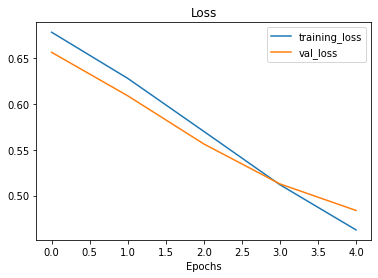

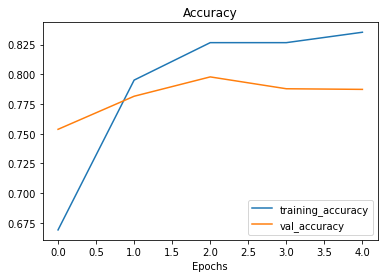

In [121]:
plot_loss_curves(model_8_history)

In [122]:
all_model_results = pd.DataFrame({'baseline':baseline_results,
                                  'simple_dense':model_1_results,
                                  'lstm_dense':model_2_results,
                                  'gru_dense':model_3_results,
                                  'USE_encoder_1':model_6_results,
                                  'USE_encoder_1_dense_layer':model_7_results,
                                  'USE_encoder_10%':model_8_results})

In [123]:
all_model_results.T

,accuracy_train,accuracy_val,precision_train,precision_val,recall_train,recall_val,f1_train,f1_val
baseline,0.889122,0.801471,0.963340,0.867893,0.771300,0.634474,0.856690,0.733051
simple_dense,0.971624,0.780462,0.977889,0.758398,0.955565,0.717604,0.966598,0.737437
lstm_dense,0.980732,0.758929,0.988736,0.724656,0.966164,0.707824,0.977320,0.716141
gru_dense,0.984411,0.746324,0.980879,0.694541,0.982878,0.731051,0.981877,0.712329
USE_encoder_1,0.836048,0.818803,0.841821,0.814077,0.761517,0.749389,0.799658,0.780395
USE_encoder_1_dense_layer,0.837625,0.820378,0.845875,0.813984,0.760701,0.754279,0.801030,0.782995
USE_encoder_10%,0.787879,0.787290,0.778226,0.766452,0.708113,0.726161,0.741515,0.745763


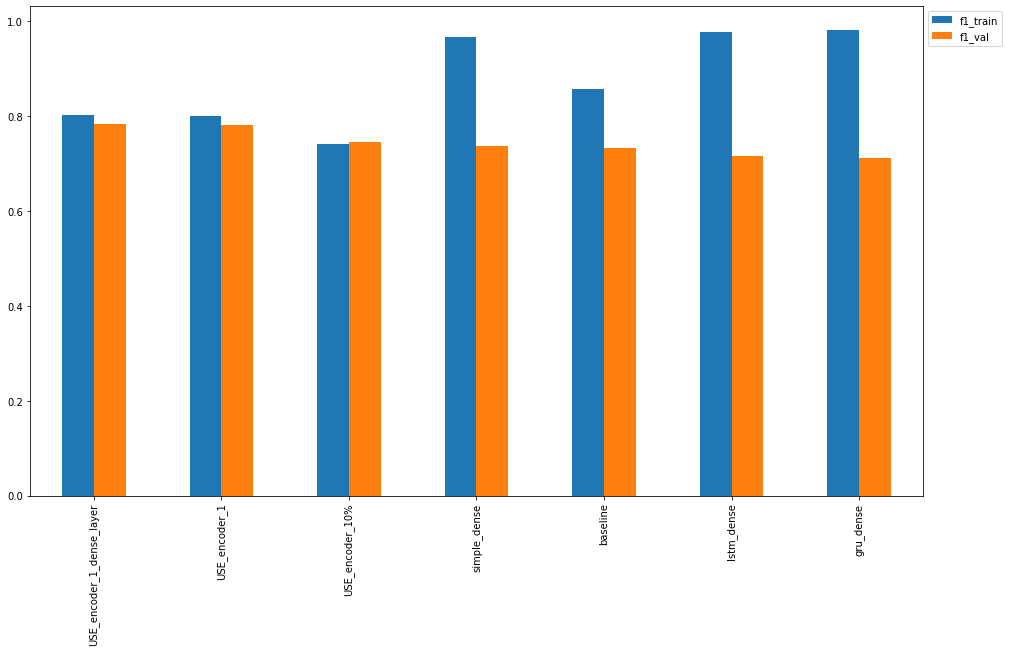

In [124]:
all_model_results.T.sort_values(by = 'f1_val' , ascending = False)[['f1_train','f1_val']].plot(kind = 'bar', figsize =(16,9)).legend(bbox_to_anchor = (1.0,1.0))

In [125]:
#view tensorboard logs of transfer learning modelling experiments

!tensorboard dev upload --logdir ./model_logs/ \
--name 'NLP Modeling Experiments' \
--description 'Comparing multiple different types of model architectures on the Kaggle Tweet disaster classification' \
--one_shot # exit the upload once uploading is finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=NyUP9pPyqbIFcAu5klgDqSirO8Fwg1&prompt=consent&access_type=offline

In [126]:
# Link to tensorboard: https://tensorboard.dev/experiment/JjcGK5f5SxOxDTpOwq0uDw/


## saving a model

In [129]:
model_7.save('model_7.h5') # saving in HDF5 format

In [130]:
#Load model with custom hub layer(required HDF5 format)
load_model_7 = tf.keras.models.load_model('model_7.h5',
                                          custom_objects = {'KerasLayer':hub.KerasLayer}) #https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [132]:
load_model_7.evaluate(X_val,y_val)

60/60 [==============================] - 2s 18ms/step - loss: 0.4137 - accuracy: 0.8204


[0.41366317868232727, 0.8203781247138977]

In [133]:
model_7_results

{'accuracy_train': 0.837624802942722,
 'accuracy_val': 0.8203781512605042,
 'f1_train': 0.8010302640051514,
 'f1_val': 0.7829949238578681,
 'precision_train': 0.8458748866727108,
 'precision_val': 0.8139841688654353,
 'recall_train': 0.7607011822258459,
 'recall_val': 0.7542787286063569}

In [134]:
### Save model format
model_7.save('model_7')

INFO:tensorflow:Assets written to: model_7/assets


INFO:tensorflow:Assets written to: model_7/assets


In [137]:
saved_model_format = tf.keras.models.load_model('model_7')

In [139]:
saved_model_format.evaluate(X_val,y_val)

60/60 [==============================] - 2s 18ms/step - loss: 0.4137 - accuracy: 0.8204


[0.41366320848464966, 0.8203781247138977]

#Error analysis

In [141]:
pred_probs = model_7.predict(X_val)

In [150]:
preds = tf.cast(tf.squeeze(tf.round(pred_probs)),dtype = tf.int16)

In [157]:
prediction_table = pd.DataFrame({'text':X_val,
                                'predictions':preds,
                                'pred_probs':tf.squeeze(pred_probs).numpy(),
                                'actual':y_val})

In [158]:
prediction_table['wrong_predictions'] = prediction_table.predictions!=prediction_table.actual 

In [163]:
mask = prediction_table['wrong_predictions'] == True
wrong_predictions = prediction_table[mask].sort_values(by = 'pred_probs', ascending = False).reset_index(drop= True)

In [173]:
most_wrong_false_positive = wrong_predictions.head(10)

In [174]:
most_wrong_false_negative = wrong_predictions.tail(10)

In [189]:
import itertools
print('----------------------------------       False Positives      -------------------------------------')
print('---------------------------------------------------------------------------------------------------')
for row in wrong_predictions.head(10).itertuples():
  _,text,preds,probs,target,_ = row
  print(f'target: {target}, predictions: {preds}, probs :{[probs]}')
  print(f'text: {text}','\n')
  print('-------------------------------------------------------------------------------------------------------')

----------------------------------       False Positives      -------------------------------------
---------------------------------------------------------------------------------------------------
target: 0, predictions: 1, probs :[0.9897798299789429]
text: DISASTER AVERTED: Police kill gunman with Û÷hoax deviceÛª atåÊcinema http://t.co/5NG0FzpVdS 

-------------------------------------------------------------------------------------------------------
target: 0, predictions: 1, probs :[0.9741340279579163]
text: @adorableappple No reported flooding po in the area. Ten-4. #mmda 

-------------------------------------------------------------------------------------------------------
target: 0, predictions: 1, probs :[0.9655008316040039]
text: Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW 

-------------------------------------------------------------------------------------------------------
target: 0, prediction

In [190]:
print('----------------------------------       False Negatives      -------------------------------------')
print('---------------------------------------------------------------------------------------------------')
for row in wrong_predictions.tail(10).itertuples():
  _,text,preds,probs,target,_ = row
  print(f'target: {target}, predictions: {preds}, probs :{[probs]}')
  print(f'text: {text}','\n')
  print('-------------------------------------------------------------------------------------------------------')

----------------------------------       False Negatives      -------------------------------------
---------------------------------------------------------------------------------------------------
target: 1, predictions: 0, probs :[0.05854713171720505]
text: @HowardU If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers? 

-------------------------------------------------------------------------------------------------------
target: 1, predictions: 0, probs :[0.05585695430636406]
text: Flattened thee striker 

-------------------------------------------------------------------------------------------------------
target: 1, predictions: 0, probs :[0.05264560505747795]
text: I can't drown my demons they know how to swim 

-------------------------------------------------------------------------------------------------------
target: 1, predictions: 0, probs :[0.04792399704456329]
text: you can stab m

In [192]:
test_df = pd.read_csv('test.csv')

In [194]:
test_pred_probs = model_7.predict(test_df['text'])

In [198]:
test_preds = tf.cast(tf.squeeze(tf.round(test_pred_probs)), dtype = tf.int16).numpy()

In [201]:
test_df['predictions'] = test_preds
test_df['prediction_prob'] = tf.squeeze(test_pred_probs).numpy()

In [206]:
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences,10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_7.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f'Pred: {int(pred)}, prob{pred_prob}')
  print(f'Text : {test_sample}')
  print('----------------------------------------')

Pred: 0, prob0.17383526265621185
Text : HillaryÛªs Bimbo Eruptions and Questionable Financial Dealings Should Derail Campaign http://t.co/kAL1s5mg2z via @politicsisdirty
----------------------------------------
Pred: 0, prob0.11381566524505615
Text : I'll let Louis drown me at the water wall by the mall If that makes him smile
----------------------------------------
Pred: 0, prob0.2503000795841217
Text : God the past few nights have been awesome but tonight it looks like the heat wave is back ?? can't breathe in my room!
----------------------------------------
Pred: 0, prob0.28235456347465515
Text : MGS4 came out during a time of great upheaval in my life and itÛªs very odd that MGSV is coming and itÛªs also when things are getting iffy
----------------------------------------
Pred: 0, prob0.0857897475361824
Text : Stop Extreme Regulations That Hurt The Middle Class http://t.co/ATp5apYxRr
----------------------------------------
Pred: 1, prob0.8371120095252991
Text : 'Prompt and u

#The speed/score tradeoff

In [212]:
import time

def pred_timer(model,samples):
  '''
  Times how long a model takes to make predictions
  '''
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()

  return end_time - start_time , (end_time - start_time)/len(samples)

In [219]:
duration_model_0 , time_per_sample_model_0 = pred_timer(model_0,X_val)
duration_model_0 , time_per_sample_model_0

(0.041350343000885914, 2.171761712231403e-05)

In [220]:
duration_model_1 , time_per_sample_model_1 = pred_timer(model_7,X_val)
duration_model_1 , time_per_sample_model_1

(0.9628272310001194, 0.000505686570903424)

In [221]:
duration_model_1/duration_model_0

23.28462501458552

In [222]:
time_per_sample_model_1/time_per_sample_model_0

23.28462501458552